In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


In [4]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import os
import glob
import sys


current_dir = os.getcwd()
# Get the grandparent directory (two levels up)
grandparent_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
# Add the grandparent directory to sys.path
sys.path.insert(0, grandparent_dir)

from utility import fluvial_dataloader
from viz import show_generated_samples

# Flexible Dimension Generation

by using U-net architecture without any flatten layer, the network can generate different realizations of different dimension

In [7]:
# load the model
net = UNet2DModel(
    sample_size=(64,64),  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# load the model
net.load_state_dict(torch.load('trained_model/model.pth'))

#

<All keys matched successfully>

(-0.5, 520.5, 520.5, -0.5)

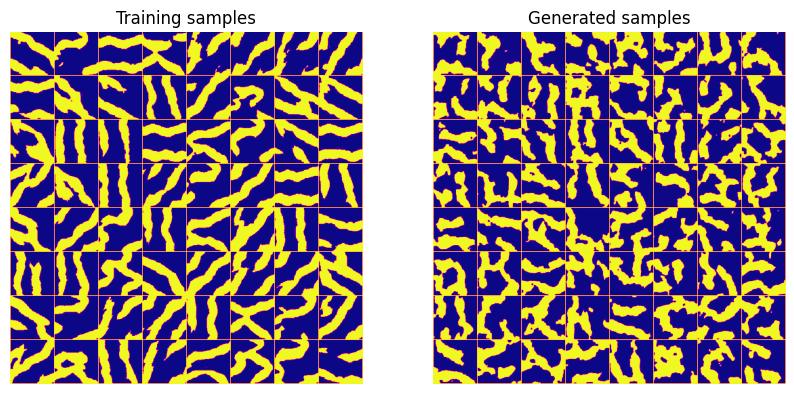

In [ ]:
# compare training samples and generated samples
# load the training data
train_dataloader = fluvial_dataloader(batch_size = 64)
for x in train_dataloader:
    train_batch = x
    # shift from [-1,1] to [0,1]
    train_batch = (train_batch + 1) / 2
    break

# generate samples
with torch.no_grad():
    n_steps = 40
    x = torch.rand(64, 1, 64, 64).to(device)
    for i in range(n_steps):
        noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
        with torch.no_grad():
            pred = net(x, 0).sample
        mix_factor = 1/(n_steps - i)
        x = x*(1-mix_factor) + pred*mix_factor
    # shift value from [-1, 1] to [0, 1]
    x = (x + 1) / 2
    generated_batch = x

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1. imshow(torchvision.utils.make_grid(train_batch.detach().cpu().clip(0, 1), 
                                              nrow=8,
                                              padding=1, pad_value=1)[0], cmap='plasma')
ax1.set_title('Training samples')
ax1.axis('off')
ax2.imshow(torchvision.utils.make_grid(generated_batch.detach().cpu().clip(0, 1),
                                                nrow=8,
                                                padding=1, pad_value=1)[0], cmap='plasma')
ax2.set_title('Generated samples')
ax2.axis('off')
fig.savefig('training_vs_generated_channel.png', dpi=300, bbox_inches='tight')

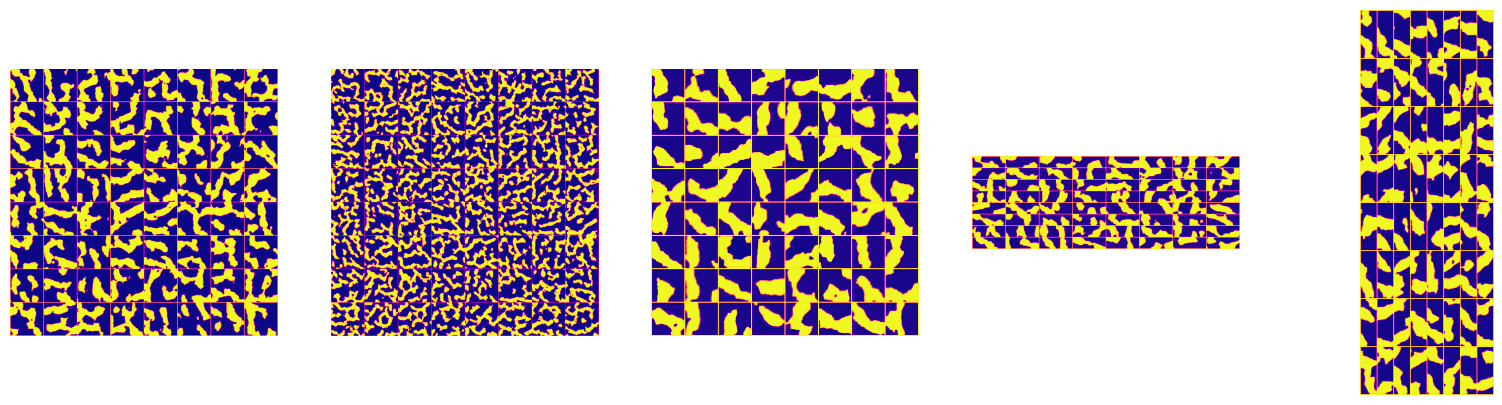

In [9]:
dimensions_set = [
    (64, 64),
    (128, 128),
    (32, 32),
    (20, 60),
    (60, 20)
]

fig, axs = plt.subplots(1, len(dimensions_set), figsize=(20, 5))
for dim, ax in zip(dimensions_set, axs):
    n_steps = 40
    x = torch.rand(64, 1, dim[0], dim[1]).to(device)
    for i in range(n_steps):
        noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
        with torch.no_grad():
            pred = net(x, 0).sample
        mix_factor = 1/(n_steps - i)
        x = x*(1-mix_factor) + pred*mix_factor
    # shift value from [-1, 1] to [0, 1]
    x = (x + 1) / 2
    ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(0, 1), 
                                              nrow=8,
                                              padding=1, pad_value=1)[0], cmap='plasma')
    ax.axis('off')
    ax.set_title(f'{dim[0]}x{dim[1]}')
fig.savefig('generated_channel_samples_different_dimensions.png', dpi=300, bbox_inches='tight')

In [ ]:
x = torch.rand(64, 1, 64,64).to(device)
pred = net(x, 0).sample
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(0, 1),
                                                nrow=8,
                                                padding=1, pad_value=1)[0], cmap='plasma')
ax1.set_title('Input')
ax1.axis('off')
ax2.imshow(torchvision.utils.make_grid(pred.detach().cpu().clip(0, 1),
                                                nrow=8,
                                                padding=1, pad_value=1)[0], cmap='plasma')
ax2.set_title('Output')


## Repaint performance


In [11]:
from diffusers import RePaintPipeline, RePaintScheduler
generator = torch.Generator(device="cuda").manual_seed(0)

/home1/junjieyu/.conda/envs/DDPM/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [16]:
from utility import get_penetrate_mask, get_random_pixel_mask

repaint_scheduler = RePaintScheduler.from_pretrained("google/ddpm-ema-celebahq-256")
repaint_pipe = RePaintPipeline(net, scheduler=repaint_scheduler)
repaint_pipe = repaint_pipe.to("cuda")

shape = (64,64)
mask = get_random_pixel_mask(shape, 0.01)
mask = mask.to(device)

sample = next(iter(train_dataloader))
sample = sample.to(device)
repaint_images = repaint_pipe(
            image=sample,
            mask_image=mask,
            num_inference_steps=100,
            eta=0.0,
            jump_length=10,
            jump_n_sample=5,
            generator=generator,
            output_type = 'numpy'
            ).images

/home1/junjieyu/.conda/envs/DDPM/lib/python3.12/site-packages/diffusers/pipelines/deprecated/repaint/pipeline_repaint.py:35: FutureWarning: The preprocess method is deprecated and will be removed in diffusers 1.0.0. Please use VaeImageProcessor.preprocess(...) instead
  deprecate("preprocess", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/820 [00:00<?, ?it/s]

In [ ]:
%load_ext autoreload
% autoreload 2

/tmp/SLURM_22473923/ipykernel_91486/909680799.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  repaint_images = torch.tensor(repaint_images)


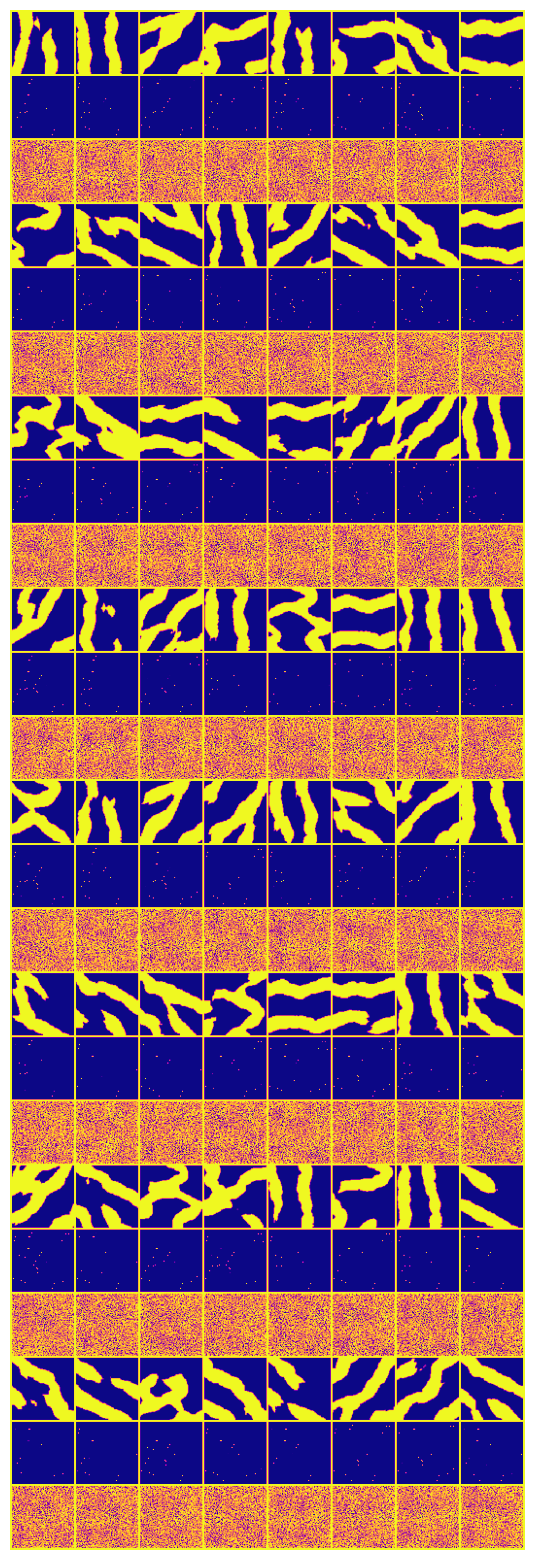

In [20]:
repaint_images = torch.tensor(repaint_images)
    
from viz import compare_repaint
compare_repaint(repaint_images, sample, mask)
